# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Initializing

In [11]:
def initialise_boundary(top, left, right, bottom, T_ambient, corners=[0,0,0,0], Get_T_K=True):
    '''
    Takes in the boundary values and fills all the middle points in with either 0 for T_0 
    or the ambient (starting) temperature to T_k
    adds the corners in either averaged with the points around them or defined prior
    '''
    cols = len(top)+2
    rows = len(left)+2
    
    middle_zeros = np.array([0 for i in top])
    
    if corners == [0,0,0,0]:
        initial_top = np.append(np.append([(top[0]+left[0])/2],top), [(top[-1]+right[0])/2])
        initial_bottom = np.append(np.append([(bottom[0]+left[-1])/2],bottom), [(bottom[-1]+right[-1])/2])
    else:
        initial_top = np.append(np.append([corners[0]],top), [corners[1]])
        initial_bottom = np.append(np.append([corners[2]],bottom), [corners[3]])
    
    
    
    middle = np.array(np.append([np.append(np.append([left[i]], middle_zeros), [right[i]]) for i in range(rows-2)],[]))
    
    initial_array = np.append(np.append(initial_top, middle), initial_bottom)
    initial_matrix_T_0 = np.matrix(initial_array.reshape(rows, cols))
    
    if not Get_T_K:
        return initial_matrix_T_0
    
    else:
        middle_ambient = np.array([T_ambient for i in top])
        middle_ambient = np.array(np.append([np.append(np.append([left[i]], middle_ambient), [right[i]]) for i in range(rows-2)],[]))
        initial_array = np.append(np.append(initial_top, middle_ambient), initial_bottom)
        initial_matrix_T_k = np.matrix(initial_array.reshape(rows, cols))
        return initial_matrix_T_0, initial_matrix_T_k

# Updates

In [12]:
def update_with_source(T_k, T_0, q, h):
    # This new update function will use the fact that there will be a source term at each of the points
    # it will also update the new T_0 with the BC
    
    T_kP1 = T_0.copy()
    
    K_si = 150
    
    length = len(T_k)
    width = len(T_k[0].A1)
    
    for i in range(1, length - 1):
        for j in range(1, width - 1):
            ## i and j now index the entire inside of the array and does not touch any of the edges
            
            # the k_si and T_a which are global variables come from dimensionless and h = 1/stepsize(m)
            T_kP1[i,j] += 1/4*(T_k[i,j+1] + T_k[i,j-1] + T_k[i+1,j] + T_k[i-1,j]) + 1/4 * q *h **2 / (K_si*T_a)
                
    return T_kP1

def update_without_source(T_k, T_0):
    T_kP1 = T_0.copy()
    
    length = len(T_k)
    width = len(T_k[0].A1)
    
    for i in range(1, length - 1):
        for j in range(1, width - 1):
            ## i and j now index the entire inside of the array and does not touch any of the edges
            
            # no source term
            T_kP1[i,j] += 1/4*(T_k[i,j+1] + T_k[i,j-1] + T_k[i+1,j] + T_k[i-1,j]) 
    
    return T_kP1

In [124]:
def update_boundary_convection(T_k, K):
    '''
    This func can be used for all of the different arrays of materials
    it calculates the update on the boundary due to convection
    the update for the boudary with different materials will be dealt with later and overwrite the relevant bdd values
    '''
    
    top = T_k[1].A1[1:-1]
    second_top = T_k[2].A1[1:-1]
    grad_top = np.array([gradient_nat_convection(i, T_a, K, h) for i in top]) 
    new_top = new_imaginary_points(grad_top, second_top, h)
    
    col_list = T_k.transpose()
    left = col_list[1].A1[1:-1]
    second_left = col_list[2].A1[1:-1]
    grad_left = np.array([gradient_nat_convection(i, T_a, K, h) for i in left])
    new_left = new_imaginary_points(grad_left, second_left, h)
    
    bottom = T_k[-2].A1[1:-1]
    second_bottom = T_k[-3].A1[1:-1]
    grad_bottom = np.array([gradient_nat_convection(i, T_a, K, h) for i in bottom])
    new_bottom = new_imaginary_points(grad_bottom, second_bottom, h)
    
    right = col_list[-2].A1[1:-1]
    second_right = col_list[-3].A1[1:-1]
    grad_right = np.array([gradient_nat_convection(i, T_a, K, h) for i in right])
    new_right = new_imaginary_points(grad_right, second_right,  h)
    
    T_0_new = initialise_boundary(new_top, new_left, new_right, new_bottom, T_a, [0,0,0,0], Get_T_K=False)
    
    return T_0_new

def calc_update_shared_bdd(T_below, T_above, k_below, k_above, T_0_below, T_0_above):
    # Pass in the second to last row from each and relative k values, this is the T_above/below variables
    # Finds the array of shared points
    # updates the two T_0 matricies by replacing the relevant values
    
    row_below, col_below = len(T_0_below), len(T_0_below[0].A1)
    row_above, col_above = len(T_0_above), len(T_0_above[0].A1)
    diff = col_above - col_below # it is assumed that the above is always bigger than the below
    
    above_middle_points = int(diff/2+1)
    
    # Takes relevant points and calculates the new imaginary point assuming gradients in and out must be equal
    new_points = (k_below*T_below[1:-1] + k_above*T_above[above_middle_points:-above_middle_points])/(k_below+k_above)
    
    # The new points are then used to rewrite the relevant parts of the T_0 matricies for the two materials
    T_below_boundary = np.matrix(np.append(np.append(T_0_below[0,0],new_points),T_0_below.A1[col_below-1:])).reshape(row_below,col_below)
    
    T_above_boundary = np.append(T_0_above.A1[:-int(col_above-1-diff/2)], np.append(new_points,T_0_above.A1[int((row_above*col_above)-1-diff/2):]))
    T_above_boundary = np.matrix(T_above_boundary).reshape(row_above,col_above)
    
    return T_below_boundary, T_above_boundary # These will be the new T_0's for the above and below case

def heat_sinc_boundary(T_below, T_above_list, T_0_below, T_0_above_list, spacing=20):
    
    number_of_fins = len(T_above_list)
    T_above = [0]
    for i, item in enumerate(T_above_list): # makes the T_above with all of the boundary points
        if i+1 != number_of_fins:
            T_above = np.append(np.append(T_above, item[1:-1]),[0 for i in range(20)])
        else:
            T_above = np.append(np.append(T_above, item[1:-1]),[0])
        
    new_points = (T_below + T_above)/(2)
    
    row_below, col_below = len(T_0_below), len(T_0_below[0].A1)
    
    # sorting out the below boundarys
    T_below_boundary_top = T_0_below[0].A1
    for i in range(number_of_fins-1): # this is not general for different dimensions, but is for more fins
        T_below_boundary_top[1+i*(10+spacing):11+i*(10+spacing)] = new_points[1+i*(10+spacing):11+i*(10+spacing)]        
    T_below_boundary_top[col_below-11:col_below-1] = new_points[col_below-11:col_below-1]
    T_below_boundary = np.matrix(np.append(T_below_boundary_top,T_0_below.A1[col_below:])).reshape(row_below,col_below)
    
    #row_above, col_above = len(T_0_above_list[0]), int(1e-3/h + 2)
    
    for index, T_0_above in enumerate(T_0_above_list):
        # take each list for  the T_0_above's, and replace the bottom with the relevant section of the new points
        T_0_above[-1][1:-1] = np.array(new_points[1+index*(10+spacing):11+index*(10+spacing)])
    
    return T_below_boundary, T_0_above_list

        
    
    
        
    
    

# Hella tests for heat sinc boundary

In [62]:
ambient = 10

top = np.array([ambient for i in range(5)])
bottom = top.copy()
left = np.array([ambient for i in range(7)])
right = left.copy()

a, b = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
d = np.array([a,b])
c = a[0].A1
i = 1
k = len(c)
#c[k-11:k-1] = np.array([3 for i in range(10)])
c
n = len(a.A1)
a.A1[n-9:]
a.A1
a
matrix = d[1]
len(matrix)
matrix[len(matrix)-1]

array([10., 10., 10., 10., 10., 10., 10.])

In [141]:
ambient = 10

sinc_length = 100
spacing = 20

top = np.array([ambient for i in range(sinc_length)])
bottom = top.copy()
left = np.array([ambient for i in range(40)])
right = left.copy()

sinc_0, sinc_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

ambient = 5

top = np.array([ambient for i in range(10)])
bottom = top.copy()
left = np.array([ambient for i in range(5)])
right = left.copy()

n_fins = int((sinc_length+spacing)/(10+spacing))
fin_0, fin_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
fins_0 = np.array([fin_0 for i in range(n_fins)])
fins_k = np.array([fin_k for i in range(n_fins)])



100


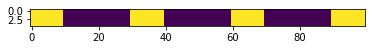

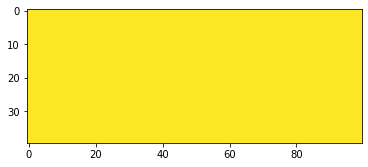

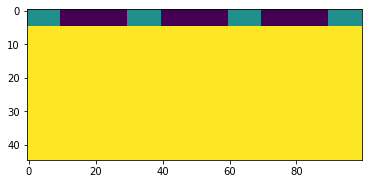

In [142]:
fins_0
plt.imshow(combine_fins(fins_k, 20))
print(len(combine_fins(fins_k, 20)[0].A1))
plt.show()

plt.imshow(trim(sinc_k), vmin=0)
plt.show()


plt.imshow(combine(combine_fins(fins_k, 20), trim(sinc_k), 0, False))

In [143]:
T_above_list = np.array([fin_k[-3] for fin_k in fins_k])
T_below = sinc_k[-3].A1

sinc_0_new, fins_0_new = heat_sinc_boundary(T_below, T_above_list, sinc_0, fins_0)


array([[[5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 5. ]],

       [[5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [5. , 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 5. ]],

       [[5. , 5.

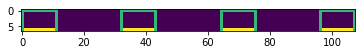

In [145]:
fins_0_new
plt.imshow(combine_fins_wo_trim(fins_0_new))
fins_0

# Calculators

In [14]:
def gradient_nat_convection(T_k_i, T_ambient, k, h):
    value = - h_nat(T_k_i, T_ambient)/ k * (T_k_i - 293/T_ambient)
    return value

def h_nat(T_s_hat, T_a):
    return 1.31*(T_s_hat*T_a - 293)**(1/3)

def new_imaginary_points(grad, previous_points, h):
    return previous_points + 2*h*grad

# Ploting functions

In [15]:
def plot(T, cbar = False):
    fig, ax = plt.subplots()
    im = ax.imshow(T, cmap='plasma')
    if cbar:
        #fig.suptitle('Temperature map')
        cbar = ax.figure.colorbar(im, orientation='horizontal')
        cbar.ax.set_xlabel('Temperature Scale')
    plt.show()

In [16]:
def trim(M):
    # takes the edge rows off a matrix
    # this is used as the T_k matricies that are generated contain the imaginary points from the neuman BC
    rows = len(M)
    cols = len(M[0].A1)
    
    M_list = M.A1[cols:-cols]
    M = np.matrix(M_list.reshape(rows-2, cols)).transpose()
    M_list = M.A1[rows-2:-(rows-2)]
    M = np.matrix(M_list.reshape(cols-2, rows-2)).transpose()
    
    return M

In [105]:
def combine(M1, M2, Temp, trim = True):
    # This function is to combine the two matricies, M1 on top and M2 on bottom
    # It assumes that the matricies contain the boundary conditions and therefore trims them both
    # It will add k to anywhere that is dead-space
    # Assumes that M1 has more cols than M2
    
    if trim:
        M1 = trim(M1)
        M2 = trim(M2)
    
    M1_rows, M1_cols = len(M1), len(M1[0].A1)
    M2_rows, M2_cols = len(M2), len(M2[0].A1)
    
    total_rows = M1_rows + M2_rows
    total_cols = M1_cols
    
    if M1_cols < M2_cols:
        raise Exception('M1 should be the bigger matrix, but it has less columns')
    
    cols_diff = M1_cols - M2_cols
    
    total_array = M1.A1
    
    for row in M2:
        ks = [Temp for i in range(int(cols_diff/2))]
        middle = np.append(np.append(ks, row),ks)
        total_array = np.append(total_array, middle)
        
    return np.matrix(total_array).reshape(total_rows, total_cols)
     

In [139]:
def combine_fins(fins, spacing=20, ambient=0):
    test_fin = trim(np.matrix(fins[0]))
    rows, cols = len(test_fin), len(test_fin[0].A1)
    number_of_fins = len(fins)
    
    total_matrix = np.array([])
    for r in range(rows):
        for f in range(number_of_fins-1):
            fin = trim(np.matrix(fins[f]))
            total_matrix = np.append(np.append(total_matrix, fin[r]),[ambient for i in range(spacing)])
        fin = trim(np.matrix(fins[-1]))
        total_matrix = np.append(total_matrix, fin[r])
    
    total_matrix = np.matrix(total_matrix).reshape(rows, (cols*number_of_fins+spacing*(number_of_fins-1)))
    
    return total_matrix  

def combine_fins_wo_trim(fins, spacing=20, ambient=0):
    test_fin = np.matrix(fins[0])
    rows, cols = len(test_fin), len(test_fin[0].A1)
    number_of_fins = len(fins)
    
    total_matrix = np.array([])
    for r in range(rows):
        for f in range(number_of_fins-1):
            fin = np.matrix(fins[f])
            total_matrix = np.append(np.append(total_matrix, fin[r]),[ambient for i in range(spacing)])
        fin = np.matrix(fins[-1])
        total_matrix = np.append(total_matrix, fin[r])
    
    total_matrix = np.matrix(total_matrix).reshape(rows, (cols*number_of_fins+spacing*(number_of_fins-1)))
    
    return total_matrix  

# Initial constant values

In [18]:
q = 0.5*1e9 # W/m^3
T_a = 293 # K
K_si = 150 # W/mK
h = 1e-4 # m

# Processor, case and heat sinc

In [ ]:
ambient = 3

# set up the processor
top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0_pr, T_k_pr = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up the case
top = np.array([ambient for i in range(200)])
bottom = top.copy()
left = np.array([ambient for i in range(20)])
right = left.copy()

T_0_cs, T_k_cs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up the main body of the heat sinc (34x4)

top = np.array([ambient for i in range(340)])
bottom = top.copy()
left = np.array([ambient for i in range(40)])
right = left.copy()

T_0_hs, T_k_hs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up heat sinc spines

top = np.array([ambient for i in range(10)])
bottom = top.copy()
left = np.array([ambient for i in range(40)])
right = left.copy()


print(len(T_0_pr[1].A1))

# Combination of ceramic case and processor Test
expected temp aproximatley in the range of 20-25 x $T_{ambient}$

### This run, we are starting below the expected value and it is clearly increasing with every run

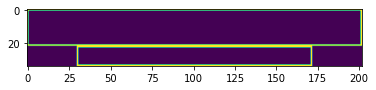

142


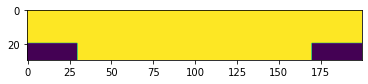

In [104]:
ambient = 20

# set up the processor
top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0_pr, T_k_pr = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up the case
top = np.array([ambient for i in range(200)])
bottom = top.copy()
left = np.array([ambient for i in range(20)])
right = left.copy()

T_0_cs, T_k_cs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

plt.imshow(combine(T_0_cs, T_0_pr, 0, False))
#plt.xlim([75,80])
plt.show()
plt.imshow(combine(T_k_cs, T_k_pr, 0))

print(len(T_0_pr[1].A1))

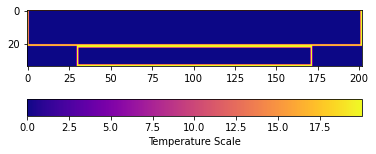

In [105]:
# First update of boundaries: we expect all boundary values to change

T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr, 150), update_boundary_convection(T_k_cs, 230)
plot(combine(T_0_cs_update, T_0_pr_update, 0, False), True)
#T_0_pr_update

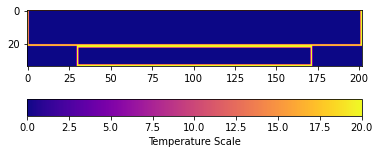

In [106]:
# First update of boundaries: this time it's the boudaries updated first but as everything starts at the same temp,
# expect the boundaries not to change

T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr[2].A1, T_k_cs[-3].A1, 150, 230, T_0_pr_update, T_0_cs_update)
# Expectation was correct

plot(combine(T_0_cs_update, T_0_pr_update, 0, False), True)
#a=25
#print(T_0_cs_update.A1[75:85],T_0_cs_update.A1[4435-a:4444-1-a])


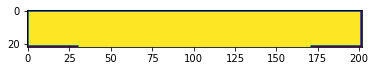

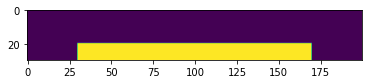

In [107]:
# Fist update of k:

T_k_pr_update = update_with_source(T_k_pr, T_0_pr_update, q, h)
T_k_cs_update = update_without_source(T_k_cs, T_0_cs_update)
plt.imshow(T_k_cs_update)
plt.show()
plt.imshow(combine(T_k_cs_update, T_k_pr_update, 20))

T: pr, cs 
 20.000038554272088 19.99999280768437


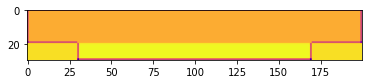


Average T, difference from 100 runs ago:
 20.000004667910815 4.667910815214782e-06
T: pr, cs 
 20.006126566502076 19.999027748570963


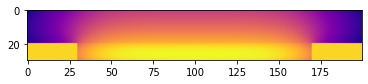


Average T, difference from 100 runs ago:
 20.0008681828494 0.0008635149385831653
T: pr, cs 
 20.007982416748643 19.999025846349834


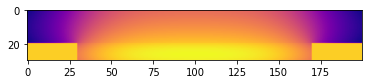


Average T, difference from 100 runs ago:
 20.00134792015693 0.0004797373075327016
T: pr, cs 
 20.009299945783496 19.999154446733964


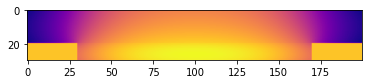


Average T, difference from 100 runs ago:
 20.00178476130236 0.0004368411454294119
T: pr, cs 
 20.01036146984192 19.999347397989787


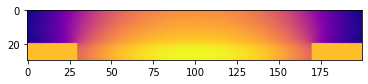


Average T, difference from 100 runs ago:
 20.0022028980996 0.00041813679724000963
T: pr, cs 
 20.011250303233446 19.999583922689663


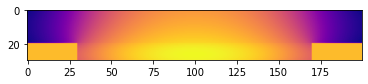


Average T, difference from 100 runs ago:
 20.00260853986768 0.0004056417680793345
T: pr, cs 
 20.01201422411401 19.99985196422498


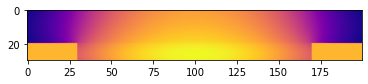


Average T, difference from 100 runs ago:
 20.00300514271473 0.0003966028470507865
T: pr, cs 
 20.01268507916381 20.000143463778624


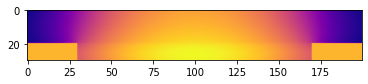


Average T, difference from 100 runs ago:
 20.0033949936933 0.00038985097856780726
T: pr, cs 
 20.013285487272586 20.000452689534693


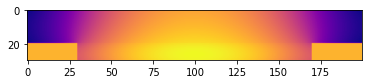


Average T, difference from 100 runs ago:
 20.003779711170445 0.0003847174771465234
T: pr, cs 
 20.01383210931691 20.00077541607232


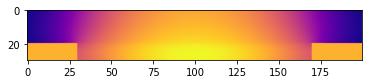


Average T, difference from 100 runs ago:
 20.004160484691287 0.00038077352084187055


In [108]:
avT_k_1 = ambient
diff_array = []
av_array = []

for i in range(10000):
    # update boundaries
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, 150), update_boundary_convection(T_k_cs_update, 230)
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, 150, 230, T_0_pr_update, T_0_cs_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    
    if i%1000 == 0:
        average_T_processor = sum(trim(T_k_pr_update).A1)/(len(trim(T_k_pr_update))*len(trim(T_k_pr_update)[1].A1))
        average_T_case = sum(trim(T_k_cs_update).A1)/(len(trim(T_k_cs_update))*len(trim(T_k_cs_update)[1].A1))
        print('T: pr, cs \n', average_T_processor, average_T_case)
        
        plot(combine(T_k_cs_update,T_k_pr_update, average_T_processor))        
        
        avT_k = (20*200*average_T_case + 140*10*average_T_processor)/(20*200+140*10)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 1000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

### We will start this run above the expected value and hopefully it should begin to fall

In [109]:
ambient = 28

# set up the processor
top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0_pr, T_k_pr = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

# set up the case
top = np.array([ambient for i in range(200)])
bottom = top.copy()
left = np.array([ambient for i in range(20)])
right = left.copy()

T_0_cs, T_k_cs = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

#plt.imshow(combine(T_0_cs, T_0_pr, 0, False))
#plt.xlim([75,80])
#plt.show()
#plt.imshow(combine(T_k_cs, T_k_pr, 0))

#print(len(T_0_pr[1].A1))

In [110]:
# first set of updates
T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr, 150), update_boundary_convection(T_k_cs, 230)
T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr[2].A1, T_k_cs[-3].A1, 150, 230, T_0_pr_update, T_0_cs_update)
T_k_pr_update = update_with_source(T_k_pr, T_0_pr_update, q, h)
T_k_cs_update = update_without_source(T_k_cs, T_0_cs_update)

T: pr, cs 
 28.000028510910035 27.99998850923474


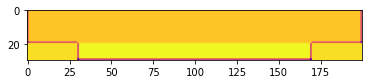


Average T, difference from 100 runs ago:
 27.999998880039445 -1.1199605545186841e-06
T: pr, cs 
 28.00302481184977 27.996286461165354


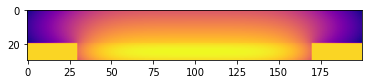


Average T, difference from 100 runs ago:
 27.998033440972424 -0.0019654390670211797
T: pr, cs 
 28.00232805344947 27.993447918129533


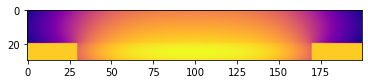


Average T, difference from 100 runs ago:
 27.995750175434704 -0.0022832655377200695
T: pr, cs 
 28.00104337660365 27.99075433079713


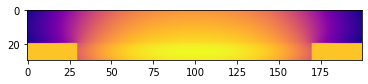


Average T, difference from 100 runs ago:
 27.99342186119141 -0.0023283142432930504
T: pr, cs 
 27.99945910988452 27.98813743159534


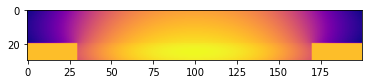


Average T, difference from 100 runs ago:
 27.991072681522162 -0.0023491796692489686
T: pr, cs 
 27.99767115272707 27.985573238235016


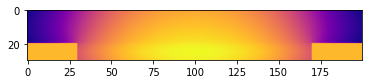


Average T, difference from 100 runs ago:
 27.98870973458481 -0.002362946937353172
T: pr, cs 
 27.995735759400997 27.983047545523867


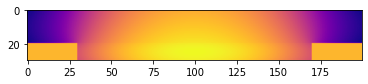


Average T, difference from 100 runs ago:
 27.98633708245497 -0.002372652129839281
T: pr, cs 
 27.99369064009409 27.98055080599083


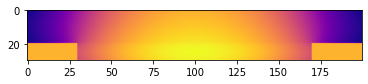


Average T, difference from 100 runs ago:
 27.983957429647234 -0.002379652807736221
T: pr, cs 
 27.991562656411208 27.978076209268135


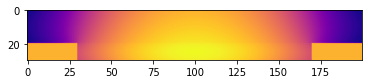


Average T, difference from 100 runs ago:
 27.981572695564488 -0.002384734082745865
T: pr, cs 
 27.98937162701873 27.975618726511613


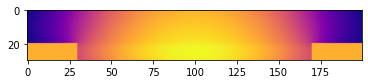


Average T, difference from 100 runs ago:
 27.979184293309753 -0.0023884022547342454


In [111]:
avT_k_1 = ambient
diff_array_2 = []
av_array_2 = []

for i in range(10000):
    # update boundaries
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, 150), update_boundary_convection(T_k_cs_update, 230)
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, 150, 230, T_0_pr_update, T_0_cs_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    
    if i%1000 == 0:
        average_T_processor = sum(trim(T_k_pr_update).A1)/(len(trim(T_k_pr_update))*len(trim(T_k_pr_update)[1].A1))
        average_T_case = sum(trim(T_k_cs_update).A1)/(len(trim(T_k_cs_update))*len(trim(T_k_cs_update)[1].A1))
        print('T: pr, cs \n', average_T_processor, average_T_case)
        
        plot(combine(T_k_cs_update,T_k_pr_update, average_T_processor))        
        
        avT_k = (20*200*average_T_case + 140*10*average_T_processor)/(20*200+140*10)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 1000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array_2.append(diff)
        av_array_2.append(avT_k)

# After doing the previous calculations, taking the shape of the solution and extrapolating to find the exact value

T: pr, cs 
 21.130966312722578 21.117052995627294


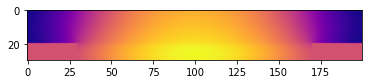


Average T, difference from 2000 runs ago:
 21.120660151911256 0.04485829130508279
T: pr, cs 
 21.130965834950224 21.117052897840402


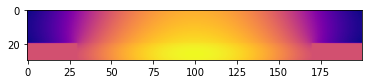


Average T, difference from 2000 runs ago:
 21.120659955609618 -1.963016380557292e-07
T: pr, cs 
 21.130967464387286 21.1170524638704


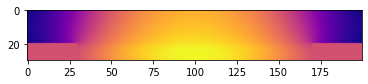


Average T, difference from 2000 runs ago:
 21.120660056597 1.0098738201236301e-07
T: pr, cs 
 21.130968385298498 21.117052209551193


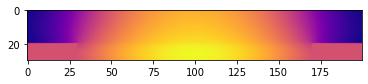


Average T, difference from 2000 runs ago:
 21.12066010696716 5.0370161375212774e-08
T: pr, cs 
 21.13096891842885 21.11705205363004


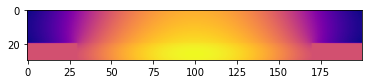


Average T, difference from 2000 runs ago:
 21.12066012968899 2.2721827974692133e-08
T: pr, cs 
 21.130969227067094 21.117051954705552


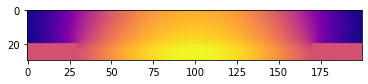


Average T, difference from 2000 runs ago:
 21.120660136428917 6.739927727039685e-09
T: pr, cs 
 21.13096940339238 21.11705188938401


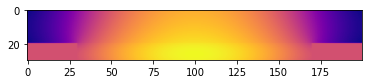


Average T, difference from 2000 runs ago:
 21.12066013375655 -2.672365440048452e-09
T: pr, cs 
 21.13096950134781 21.117051843972387


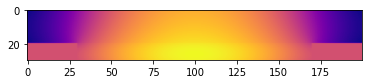


Average T, difference from 2000 runs ago:
 21.120660125514163 -8.242388105372811e-09
T: pr, cs 
 21.13096955282335 21.11705181037454


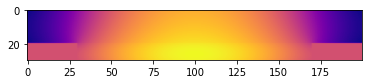


Average T, difference from 2000 runs ago:
 21.12066011397238 -1.15417826407338e-08
T: pr, cs 
 21.13096957672404 21.117051783790803


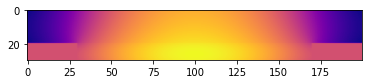


Average T, difference from 2000 runs ago:
 21.1206601004772 -1.3495181860889716e-08
T: pr, cs 
 21.13096958426578 21.11705176137391


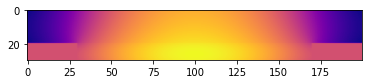


Average T, difference from 2000 runs ago:
 21.120660085827357 -1.4649842228209309e-08
T: pr, cs 
 21.13096958210399 21.117051741434132


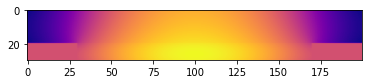


Average T, difference from 2000 runs ago:
 21.120660070496687 -1.533067006675992e-08
T: pr, cs 
 21.13096957418819 21.117051722968842


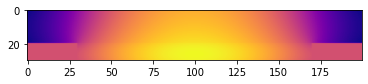


Average T, difference from 2000 runs ago:
 21.12066005476645 -1.5730236668787256e-08
T: pr, cs 
 21.130969562862006 21.11705170538293


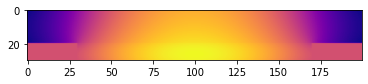


Average T, difference from 2000 runs ago:
 21.120660038803432 -1.5963017574449623e-08
T: pr, cs 
 21.130969549516625 21.11705168832333


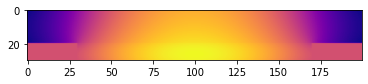


Average T, difference from 2000 runs ago:
 21.120660022706776 -1.6096656452191382e-08
T: pr, cs 
 21.13096953497719 21.117051671580544


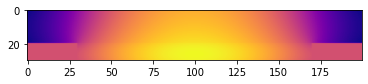


Average T, difference from 2000 runs ago:
 21.12066000653523 -1.6171547656540497e-08


KeyboardInterrupt: 

In [119]:
diff_array_2 = []
av_array_2 = []

change = -0.04484919703096324 # in the negative direction therefore make it -ve to be a +ve change

# update boundaries
T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update - change, 150), update_boundary_convection(T_k_cs_update - change, 230)
T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1 - change, T_k_cs_update[-3].A1 - change, 150, 230, T_0_pr_update, T_0_cs_update)

# update inside temps
T_k_pr_update = update_with_source(T_k_pr_update - change, T_0_pr_update, q, h)
T_k_cs_update = update_without_source(T_k_cs_update - change, T_0_cs_update)


for i in range(1000000):
    # update boundaries
    T_0_pr_update, T_0_cs_update = update_boundary_convection(T_k_pr_update, 150), update_boundary_convection(T_k_cs_update, 230)
    T_0_pr_update, T_0_cs_update = calc_update_shared_bdd(T_k_pr_update[2].A1, T_k_cs_update[-3].A1, 150, 230, T_0_pr_update, T_0_cs_update)
    
    # update inside temps
    T_k_pr_update = update_with_source(T_k_pr_update, T_0_pr_update, q, h)
    T_k_cs_update = update_without_source(T_k_cs_update, T_0_cs_update)
    
    if i%2000 == 0:
        average_T_processor = sum(trim(T_k_pr_update).A1)/(len(trim(T_k_pr_update))*len(trim(T_k_pr_update)[1].A1))
        average_T_case = sum(trim(T_k_cs_update).A1)/(len(trim(T_k_cs_update))*len(trim(T_k_cs_update)[1].A1))
        print('T: pr, cs \n', average_T_processor, average_T_case)
        
        plot(combine(T_k_cs_update,T_k_pr_update, average_T_case))        
        
        avT_k = (20*200*average_T_case + 140*10*average_T_processor)/(20*200+140*10)
        diff = avT_k-avT_k_1
        print('\nAverage T, difference from 2000 runs ago:\n',avT_k, diff)
        avT_k_1 = avT_k

    if i%2000 == 0 and i >= 10000:

        diff_array_2.append(diff)
        av_array_2.append(avT_k)

In [120]:
import pandas as pd

data = np.matrix([av_array_2, diff_array_2])
df = pd.DataFrame(data.transpose())
df.columns = ['AverageTemp', 'DiffFromLast1kIterations']
df.to_csv("pc_sc_test_after_optim", index=False)

In [121]:
# saving the processor
data = combine(T_k_cs_update, T_k_pr_update, 1)
df = pd.DataFrame(data)
df.to_csv("pr_sc_heat_matrix_after_optim", index=False)

# Rough calculations for expected multiple of ambient temperature for with ceramic casing and with heat sinc

In [10]:
# with ceramic still aprox 20-25
1+1/293*(7e6/(1.31*46))**(3/4)

# with heat-sinc aproximatley 4 so around order of magnitude less but still nowhere near enough
37*2+28*2+9*60
1+1/293*(7e6/(1.31*670))**(3/4)

3.880357113054247

# Test for shared boundary function, overwriting the relevant boundary terms and to see if combine function works

In [47]:
ambient = 40

top = np.array([ambient for i in range(6)])
bottom = top.copy()
left = np.array([ambient for i in range(3)])
right = left.copy()

T_0, T_0_below = initialise_boundary(top, left, right, bottom, 18,[ambient,ambient,ambient,ambient])

top = np.array([ambient for i in range(12)])
bottom = top.copy()
left = np.array([ambient for i in range(4)])
right = left.copy()

T_0, T_0_above = initialise_boundary(top, left, right, bottom, 18,[ambient,ambient,ambient,ambient])

In [48]:
row_below = len(T_0_below)
col_below = len(T_0_below[0].A1)
new_points = [10 for i in range(col_below-2)]
T_below_boundary = np.matrix(np.append(np.append(T_0_below[0,0],new_points),T_0_below.A1[col_below-1:])).reshape(row_below,col_below)
T_below_boundary

matrix([[40., 10., 10., 10., 10., 10., 10., 40.],
        [40., 18., 18., 18., 18., 18., 18., 40.],
        [40., 18., 18., 18., 18., 18., 18., 40.],
        [40., 18., 18., 18., 18., 18., 18., 40.],
        [40., 40., 40., 40., 40., 40., 40., 40.]])

In [49]:
row_above = len(T_0_above)
col_above = len(T_0_above[0].A1)
diff = col_above-col_below
#a = T_0_above.A1[:-int(col_above-1-diff/2)]
#b = T_0_above.A1[int((row_above*col_above)-1-diff/2):]
#print(a)
#print(new_points)
#print(b)
#print(diff)
T_below_boundary = np.matrix(np.append(np.append(T_0_below[0,0],new_points),T_0_below.A1[col_below-1:])).reshape(row_below,col_below)
T_above_boundary = np.append(T_0_above.A1[:-int(col_above-1-diff/2)], np.append(new_points,T_0_above.A1[int((row_above*col_above)-1-diff/2):]))
T_above_boundary = np.matrix(T_above_boundary).reshape(row_above,col_above)
T_above_boundary

matrix([[40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 40., 40., 40., 10., 10., 10., 10., 10., 10., 40., 40., 40.,
         40.]])

In [50]:
print(T_0_above.A1[:-(col_above)])
T_0_above

[40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 40. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 40. 40. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 40. 40. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 40. 40. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 40.]


matrix([[40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
         40.],
        [40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40.]])

In [51]:
list_1 = np.array([i*10 for i in range(12)])
list_2 = np.array([10 for i in range(6)])
diff = len(list_1) - len(list_2)
mid = int(1+diff/2)
print(list_2[1:-1])
print(list_1[mid:-mid])

[10 10 10 10]
[40 50 60 70]


In [54]:
print(trim(T_above_boundary),'\n', trim(T_below_boundary))
print(combine(T_above_boundary, T_below_boundary, 1))
combine(T_below_boundary, T_above_boundary, 1)

[[18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]] 
 [[18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18.]]
[[18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]
 [ 1.  1.  1. 18. 18. 18. 18. 18. 18.  1.  1.  1.]
 [ 1.  1.  1. 18. 18. 18. 18. 18. 18.  1.  1.  1.]
 [ 1.  1.  1. 18. 18. 18. 18. 18. 18.  1.  1.  1.]]


Exception: M1 should be the bigger matrix, but it has less columns